In [1]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import pandas as pd

2021.07.06

通过python脚本绘制时间、纬向剖面

前处理部分，将所有降水变量处理问统一的坐标（来自CN05.1）

合并到 var 字典之中，用作后续的绘图

remains：
- 调整色标
- 将时间ticks旋转下

In [2]:
dir_in = "/raid52/yycheng/MPAS/REFERENCE/TEMP_DATA/mask_pre/mask_res_dayofyear/"
filename_cn051  = "ydaymean_mask_sel_CN05.1_Pre_1961_2018_daily_025x025.nc"
filename_cmorph = "ydaymean_mask_sel_CMORPH_98-17.nc"
filename_vr     = "ydaymean_mask_vr_pre_98-17.nc"
filename_rcm    = "ydaymean_mask_rcm_pre_98-17.nc"

ds_or = {}
ds_or['cn051']  = xr.open_dataset(dir_in + filename_cn051)
ds_or['cmorph'] = xr.open_dataset(dir_in + filename_cmorph)
ds_or['vr']     = xr.open_dataset(dir_in + filename_vr)
ds_or['rcm']    = xr.open_dataset(dir_in + filename_rcm  )
# 提取变量
var = {}
var['cn051'] = ds_or['cn051']['pre']
var['cmorph'] = ds_or['cmorph']['cmorph'][:, 0, :, :]
var['vr'] = ds_or['vr']['precip_MPAS']
var['rcm'] = ds_or['rcm']['precip_MPAS']
# change coords
var_list = ['cn051','cmorph', 'vr', 'rcm']
for i in var_list:
    rename_dict = dict(zip(var[i].coords.keys(), var['cn051'].coords.keys()))
    # show converting coords
    for rename_i in rename_dict:
        print(rename_i + " -----converting to----- " + rename_dict[rename_i])

    var[i] = var[i].rename(rename_dict)
    var[i]._coords = var['cn051']._coords
    var[i] = var[i].rename(i)


/m2data2/yycheng/anaconda3/envs/proplot0528/lib/python3.8/site-packages/xarray/coding/times.py:117: SerializationWarning: Ambiguous reference date string: 1-1-1 00:00:00. The first value is assumed to be the year hence will be padded with zeros to remove the ambiguity (the padded reference date string is: 0001-1-1 00:00:00). To remove this message, remove the ambiguity by padding your reference date strings with zeros.
  warnings.warn(warning_msg, SerializationWarning)


time -----converting to----- time
lon -----converting to----- lon
lat -----converting to----- lat
time -----converting to----- time
lon -----converting to----- lon
lat -----converting to----- lat
Time -----converting to----- time
longitude -----converting to----- lon
latitude -----converting to----- lat
Time -----converting to----- time
longitude -----converting to----- lon
latitude -----converting to----- lat


In [3]:
region_dict = {}
lat = var['cn051'].lat
lon = var['cn051'].lon
time= var['cn051'].time
region_dict['lat'] = lat[(lat>=10) & (lat<=60)]
region_dict['lon'] = lon[(lon>=110) & (lon<=140)]
var_lattime = {}
for ivar in var.keys():
    var_lattime[ivar] = var[ivar].sel(region_dict).mean('lon')

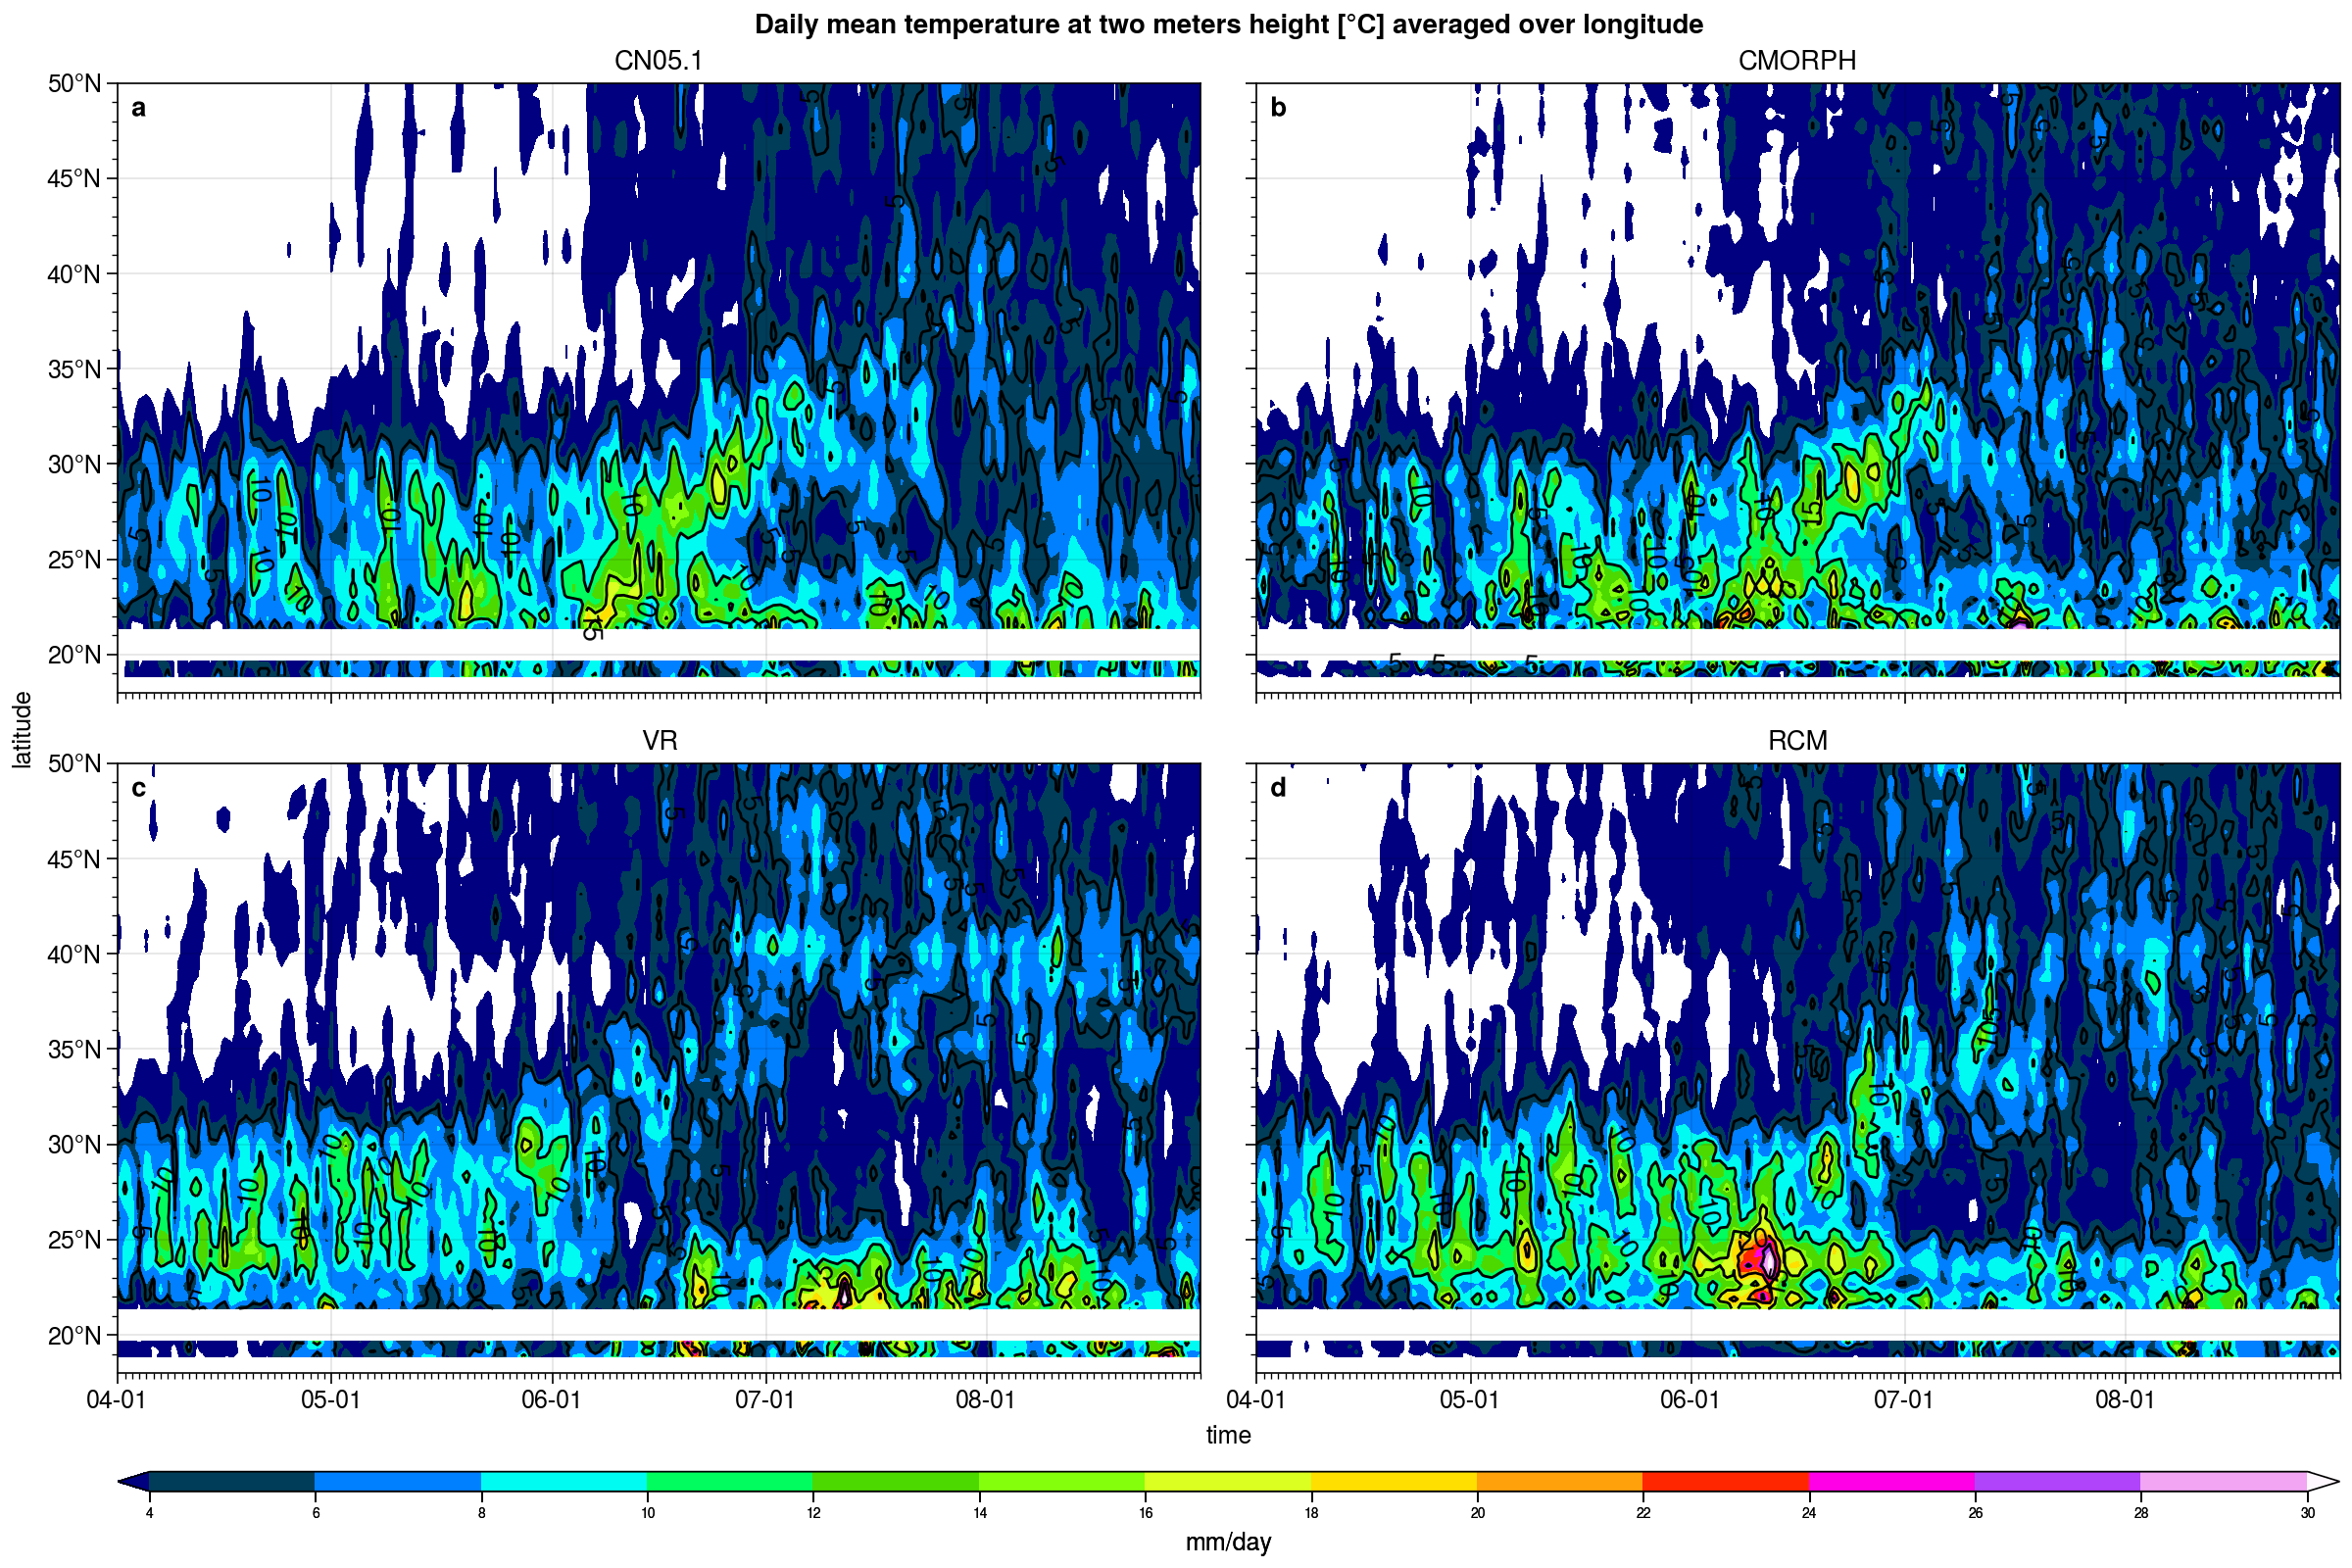

In [4]:
# import proplot as plot
from matplotlib import pyplot as plt
import proplot as plot
# ----- get filter vars coords-----

cmap="gist_ncar"
# cmap="tab20"

lat_sel  = var_lattime['cn051'].lat
# time_sel = var_lattime['cn051'].time.dt.strftime("%m-%d")
time_sel = var_lattime['cn051'].time.values

ticks = np.arange(2,33,2.)
ticks_contour = np.arange(5,30,5.)
#----- create plot -----
fig, axs = plot.subplots(ncols=2,nrows=2,figsize=(12,8))

#-----2012-----
axs[0].format(title='CN05.1')
axs[1].format(title='CMORPH')
axs[2].format(title='VR')
axs[3].format(title='RCM')
# m = axs[0].contour(lon_sel, time_sel, var_lattime['cn051'],\
# levels=ticks,color='k',
# linewidth = .5)
for i, ivar in enumerate(var_list):
    m_overlay = axs[i].contourf(time_sel,  lat_sel, var_lattime[ivar].values.T, cmap=cmap,\
    levels=ticks)
    m_contour = axs[i].contour(time_sel,  lat_sel, var_lattime[ivar].values.T,\
    levels=ticks_contour,linewidth=1,color='k')
    axs[i].clabel(m_contour, inline=True, fontsize=10, colors = 'k', fmt='%2.0f',use_clabeltext=True, inline_spacing=0)
# format作为整个proplot集中对属性进行修改的method
axs.format(
xlocator=('month', [4,5,6,7,8]),
xminorlocator='day',
# xlocator='weekday',
xformatter='%m-%d',
yformatter='deglat',
xrotation=0,  # rotated time ticks
ylim=(18,50),
abc=True, abcloc='ul',
xlabel='time',
ylabel='latitude',
suptitle="Daily precipitation averaged over longitude"
)

# for tick in axs.get_xticklabels():
    # tick.set_rotation(45)
#----- add contour tick labels -----
fig.colorbar(m_overlay, loc='b', length = 1., width=0.1,extend='both', label='mm/day',
ticklabelsize=5,ticks=ticks)

fig.patch.set_facecolor('white')
plt.savefig('./output_pic/precip_98-17_lat-time_py.png', dpi=600, facecolor= "white")